In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1235263960525214516
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10083106816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12955170832448204862
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
import torch
print(torch.__version__)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('학습을 진행하는 기기:',device)

c:\Users\phy00\anaconda3\envs\Sleep\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.0
학습을 진행하는 기기: cuda:0


In [3]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Conv1D, BatchNormalization
from keras.layers import Activation, MaxPool1D, GlobalAveragePooling1D
from keras.layers import Dense, GaussianDropout, TimeDistributed
from keras.models import Model

import mne
from mne.datasets.sleep_physionet.age import fetch_data

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [4]:
subjects = range(30)
recordings = [1]

# To load all subjects and recordings, uncomment the next line
# subjects, recordings = range(83), [1, 2]

In [5]:
fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')

In [6]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

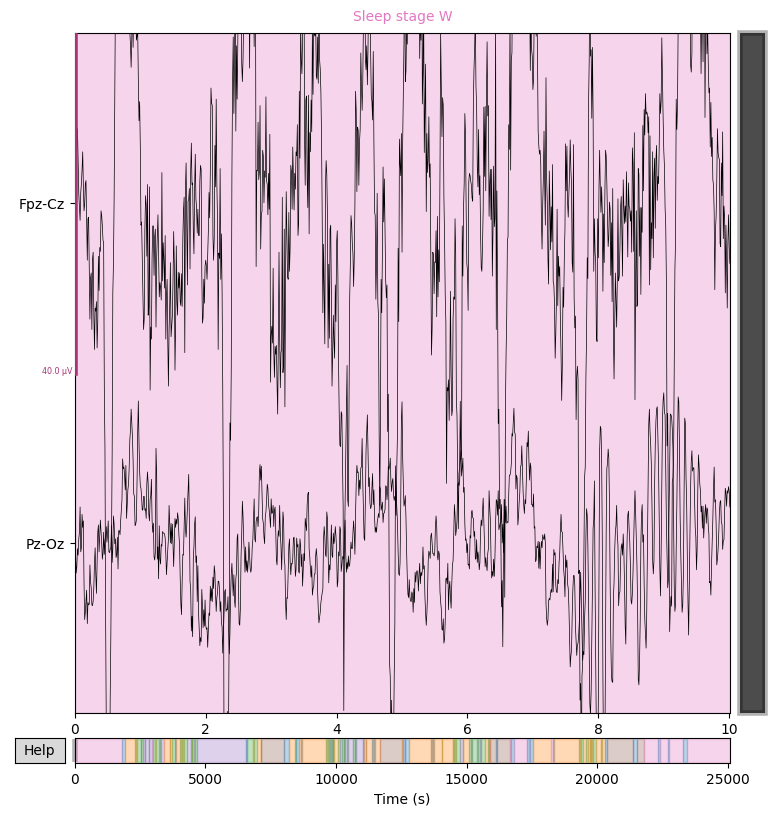

In [7]:
# Load recordings
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

# Plot a recording as a sanity check
raws[0].plot();

In [8]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place

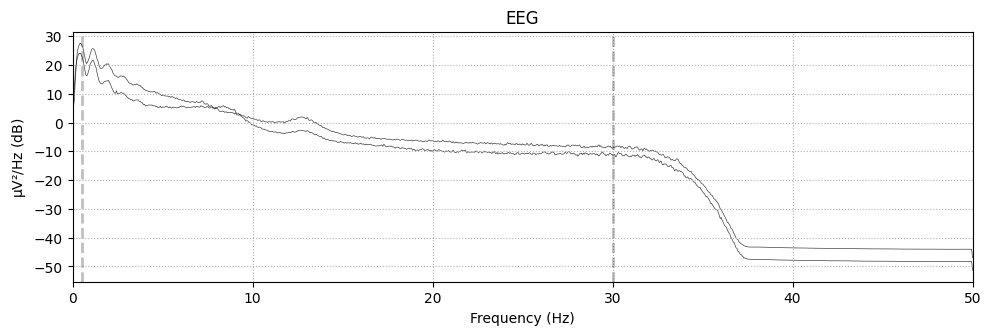

In [9]:
# Plot the power spectrum of a recording as sanity check
raws[0].plot_psd();

In [10]:
global event_id

event_id = {
        'Sleep stage W': 1,
        'Sleep stage Light': 2,
        'Sleep stage Deep': 3,
        'Sleep stage R': 4}
        
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 2,
        'Sleep stage 3': 3,
        'Sleep stage 4': 3,
        'Sleep stage R': 4}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage Light Sleep': 2,
        'Sleep stage Deep Sleep': 3,
        'Sleep stage REM': 4}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

In [11]:
import torch
print(torch.__version__)
torch.cuda.is_available()

1.13.0


True

In [12]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    

def scale(X):
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [13]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], 
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale) 
                for raw in raws]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

In [14]:
np.shape(dataset)

c:\Users\phy00\anaconda3\envs\Sleep\lib\site-packages\numpy\core\fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
c:\Users\phy00\anaconda3\envs\Sleep\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(32489, 2)

In [15]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.        
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.
        
    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from 
        `dataset` were picked.
    """
    pick_idx = list()
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)
                
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None
    
    return pick_ds, remaining_ds
    

def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [16]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(87)
np.random.seed(87)

In [17]:
# Use recording 1 of subjects 0-9 as test set
test_recs = [(subj_nb, rec_nb)  # DO NOT CHANGE! This is a fixed set.
             for subj_nb, rec_nb in zip(range(10), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 18545
Validation: 4094
Test: 9850


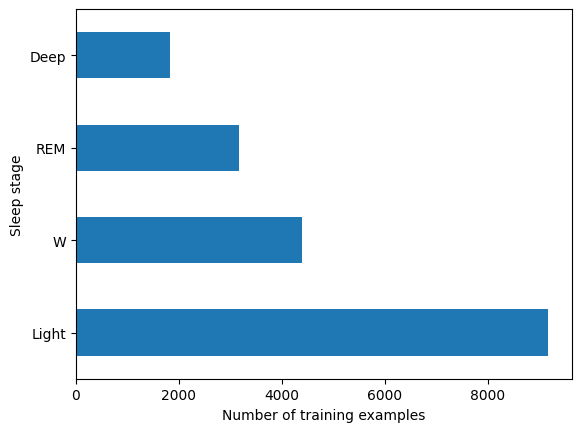

In [18]:
# classes_mapping = {0: 'W', 1: 'N1', 1: 'N2', 2: 'N3', 3: 'R'}
classes_mapping = {0: 'W', 1: 'Light', 2:'Deep', 3:'REM'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Sleep stage')
ax.figure


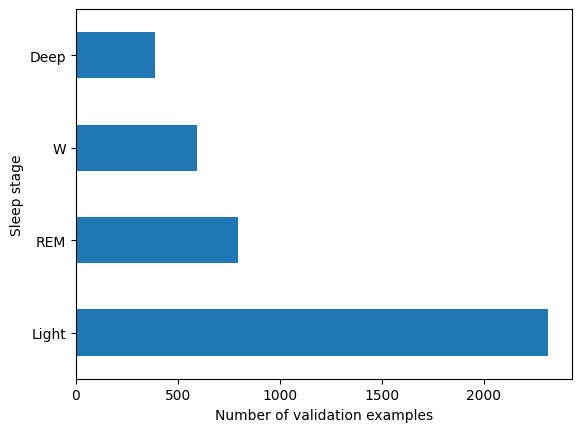

In [38]:
# classes_mapping = {0: 'W', 1: 'N1', 1: 'N2', 2: 'N3', 3: 'R'}
classes_mapping = {0: 'W', 1: 'Light', 2:'Deep', 3:'REM'}
y_train = pd.Series([y for _, y in valid_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of validation examples')
ax.set_ylabel('Sleep stage')
ax.figure


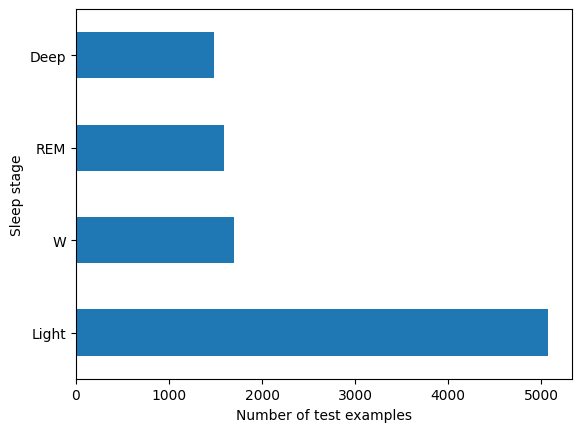

In [39]:
# classes_mapping = {0: 'W', 1: 'N1', 1: 'N2', 2: 'N3', 3: 'R'}
classes_mapping = {0: 'W', 1: 'Light', 2:'Deep', 3:'REM'}
y_train = pd.Series([y for _, y in test_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of test examples')
ax.set_ylabel('Sleep stage')
ax.figure

In [19]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[1.05729761 0.50531335 2.54459385 1.46577616]


In [20]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=4, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [21]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=4)

In [22]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cuda:0'.


In [23]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [24]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()
        
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf
        

def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [25]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [26]:
n_epochs = 50
patience = 10

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 0.8553 	 0.7392 	 0.3801 	 0.4387
best val loss inf -> 0.7392
2 	 0.5907 	 0.5578 	 0.5649 	 0.6178
best val loss 0.7392 -> 0.5578
3 	 0.5004 	 0.5493 	 0.6347 	 0.5878
best val loss 0.5578 -> 0.5493
4 	 0.4482 	 0.5153 	 0.6703 	 0.5968
best val loss 0.5493 -> 0.5153
5 	 0.4323 	 0.5495 	 0.6846 	 0.5678
6 	 0.4135 	 0.5674 	 0.6943 	 0.5543
7 	 0.4040 	 0.5191 	 0.7009 	 0.6158
8 	 0.3962 	 0.5114 	 0.7038 	 0.6015
best val loss 0.5153 -> 0.5114
9 	 0.3854 	 0.5455 	 0.7088 	 0.5950
10 	 0.3766 	 0.4855 	 0.7170 	 0.6437
best val loss 0.5114 -> 0.4855
11 	 0.3715 	 0.4725 	 0.7229 	 0.6449
best val loss 0.4855 -> 0.4725
12 	 0.3670 	 0.4921 	 0.7229 	 0.6292
13 	 0.3800 	 0.5054 	 0.7147 	 0.6224
14 	 0.3548 	 0.4821 	 0.7282 	 0.6355
15 	 0.3512 	 0.4994 	 0.7289 	 0.6247
16 	 0.3451 	 0.4822 	 0.7344 	 0.6341
17 	 0.3420 	 0.4858 	 0.7375 	 0.6527
18 	 0

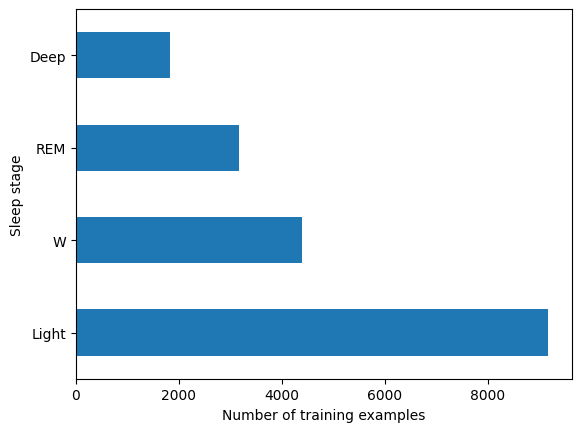

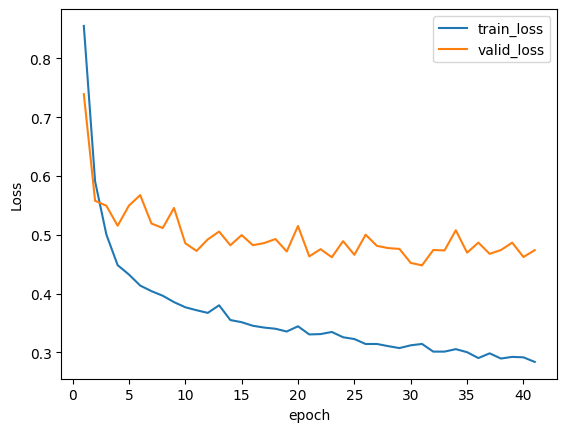

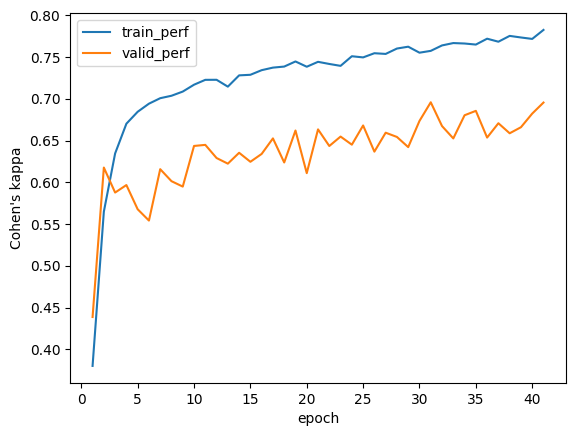

In [27]:
# Visualizing the learning curves
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'])
ax1.set_ylabel('Loss')
plt.show()
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'])
ax2.set_ylabel('Cohen\'s kappa')
plt.show()

In [34]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())
    
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.865
Test Cohen's kappa: 0.730


In [35]:
# 6. Visualizing results

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_marks = np.arange(len(ticks))
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    ax.set_yticks(tick_marks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()
    
    return fig, ax

In [36]:
# Normalized

from sklearn.metrics import confusion_matrix
import seaborn as sns

def normal_plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    sns.heatmap(conf_mat, annot=True, fmt='.2f', 
                xticklabels=ticks, yticklabels=ticks, cmap=plt.cm.Reds)


    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Normalized Confusion matrix')
    fig.tight_layout()
    
    return fig, ax

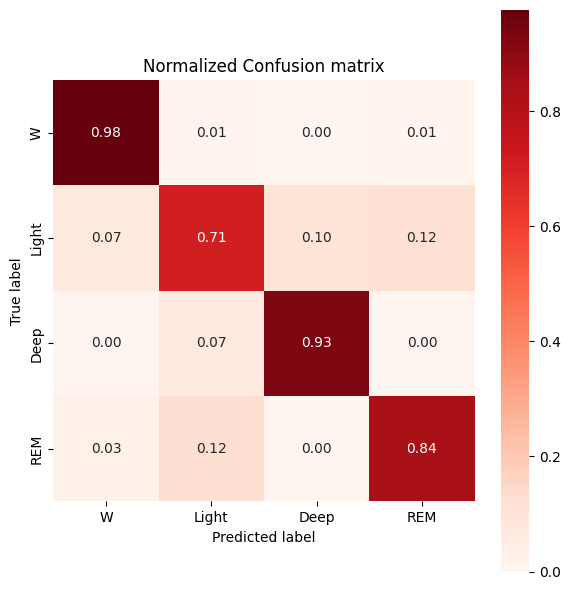

In [31]:
# Normalized confusion matrix
cm = confusion_matrix(y_true, y_pred)
n_cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] #합이 1이 되록
normal_plot_confusion_matrix(n_cm, classes_mapping);

plt.show()

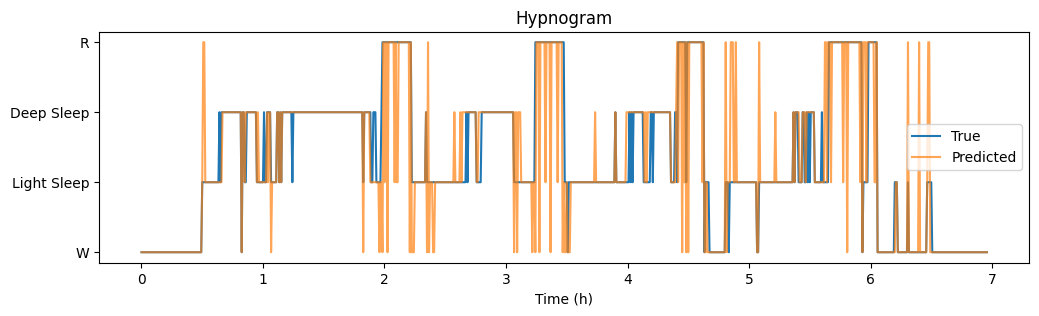

In [32]:
# Plot hypnogram for one recording

mask = rec_ids == 0  # pick a recording number

t = np.arange(len(y_true[mask])) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true[mask], label='True')
ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['W', 'Light Sleep', 'Deep Sleep', 'R'])
ax.set_xlabel('Time (h)')
ax.set_title('Hypnogram')
ax.legend();
plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=event_id.keys()))

                   precision    recall  f1-score   support

    Sleep stage W       0.80      0.98      0.88      1697
Sleep stage Light       0.92      0.71      0.80      5076
 Sleep stage Deep       0.74      0.93      0.82      1483
    Sleep stage R       0.68      0.84      0.75      1594

         accuracy                           0.81      9850
        macro avg       0.78      0.87      0.81      9850
     weighted avg       0.83      0.81      0.81      9850

